# Digital Twin

[Link to Article](https://towardsdatascience.com/supply-chain-sustainability-reporting-with-python-161c1f63f267)

To create a digital twin of a supply chain using Python, you first need to define the various components and processes that make up the supply chain.

Next, you would need to collect data on the various components and processes of the supply chain, such as

- Locations and **capacities of warehouses**
- Routes and capacities of **transportation networks**
- Production rates of production facilities
- Customer and store demand

## Simulation blocks

---

Once you have the data on the supply chain components and processes, you can use Python to create algorithms and simulations that replicate the supply chain's behaviour.

- Determine the most efficient routes*(output)* to **deliver stores** using replenishment orders *(input)* coming from the store model
- Improve the picking processes *(output)* in your warehouse to prepare store replenishment orders *(input)*
- Schedule your production (output) based on demand forecasts built with the stores’ sales historical data (input)

### Warehouse

In [58]:
# Define a Warehouse class to represent a warehouse
class Warehouse:
    def __init__(self, location, capacity):
        self.location = location
        self.capacity = capacity
        self.inventory = {}
        
    def add_inventory(self, item, quantity):
        if item in self.inventory:
            # either add to inventory or update quantity
            self.inventory[item] += quantity
        else:
            self.inventory[item] = quantity
            
    def remove_inventory(self, item, quantity):
        # check if item is in inventory and if there is enough quantity to remove
        if item in self.inventory and self.inventory[item] >= quantity:
            self.inventory[item] -= quantity
        else:
            print("Error: Not enough inventory to fulfill order.")


In [59]:

# Create a warehouse at location "New York" with a capacity of 100
warehouse = Warehouse("New York", 100)

# Add 10 units of item "A" to the warehouse's inventory
warehouse.add_inventory("A", 10)

# Remove 5 units of item "A" from the warehouse's inventory
warehouse.remove_inventory("A", 5)

print(f'Warehouse inventory: {warehouse.inventory}')

Warehouse inventory: {'A': 5}


```{note}
if your final goal is to use the insights this model provides, ensure that all the stakeholders validate the assumptions and parameters used to build it.
```

### Trucks

In [60]:
# Define a Truck class to represent a truck
class Truck:
    def __init__(self, location, capacity):
        self.location = location
        self.capacity = capacity
        self.cargo = {}
        
    def load_cargo(self, item, quantity):
        # check if there is enough capacity to load cargo
        if sum(self.cargo.values()) + quantity <= self.capacity:
            # either add to cargo or update quantity
            if item in self.cargo:
                self.cargo[item] += quantity
            else:
                self.cargo[item] = quantity
        else:
            print("Error: Not enough capacity to load cargo.")
            
    def unload_cargo(self, item, quantity):
        # check if item is in cargo and if there is enough quantity to unload
        if item in self.cargo and self.cargo[item] >= quantity:
            self.cargo[item] -= quantity
        else:
            print("Error: Cargo not found.")
            
    def move_to(self, location):
        self.location = location

In [61]:
# Create a truck at location "Paris" with a capacity of 100
truck = Truck("Paris", 100)

# Load 50 units of item "A" onto the truck
truck.load_cargo("A", 50)

# Move the truck to location "Lille"
truck.move_to("Lille")

# Unload 25 units of item "A" from the truck
truck.unload_cargo("A", 25)

print(f'Truck cargo: {truck.cargo}')

Truck cargo: {'A': 25}


### Store

In [62]:
# Define a Store class to represent a store
class Store:
    def __init__(self, location, inventory):
        self.location = location
        self.inventory = inventory
        
    def place_order(self, item, quantity):
        if item in self.inventory and self.inventory[item] >= quantity:
            self.inventory[item] -= quantity
            print("Order fulfilled.")
        else:
            print("Error: Not enough inventory to fulfill order.")

In [63]:
# Create a store at location "New York" with 10 units of item "A" in inventory
store = Store("New York", {"A": 10})

# Place an order for 5 units of item "A"
store.place_order("A", 5)

print(f'Store inventory: {store.inventory}')

Order fulfilled.
Store inventory: {'A': 5}


# Playground

here I'm playing aroung with different concepts, simulating the supply chain over time logging demand and inventory and trying out optimization examples

## Simulation

In [64]:
import random
import matplotlib.pyplot as plt

class SupplyChainSimulation:
    def __init__(self, warehouses, trucks, stores,
                 restock_threshold=20, restock_amount=50):
        """
        restock_threshold: If warehouse inventory < this value, we restock.
        restock_amount: How many units of an item to add during restock.
        """
        self.warehouses = warehouses
        self.trucks = trucks
        self.stores = stores
        self.time_step = 0
        
        self.restock_threshold = restock_threshold
        self.restock_amount = restock_amount

        # Demand log: list of dicts, each with time_step, store, item, quantity
        self.demand_log = []
        # Inventory log: list of dicts, each with time_step, warehouse_location, item, quantity
        self.inventory_log = []

    def run_step(self):
        print(f"--- Time Step {self.time_step} ---")

        items = ["WidgetA", "WidgetB", "WidgetC"]  # possible SKUs
        for store in self.stores:
            item_to_order = random.choice(items)
            quantity_to_order = random.randint(5, 15)
            print(f"Store at {store.location} requests {quantity_to_order} units of {item_to_order}.")

            # LOG the demand
            self.demand_log.append({
                "time_step": self.time_step,
                "store_location": store.location,
                "item": item_to_order,
                "quantity": quantity_to_order
            })

            # We'll just use the first truck & first warehouse for demonstration
            truck = self.trucks[0]
            warehouse = self.warehouses[0]

            # Move truck to warehouse
            if truck.location != warehouse.location:
                truck.move_to(warehouse.location)

            # Check warehouse inventory & load cargo
            if item_to_order in warehouse.inventory and warehouse.inventory[item_to_order] >= quantity_to_order:
                print(f"Loading {quantity_to_order} of {item_to_order} onto truck.")
                warehouse.remove_inventory(item_to_order, quantity_to_order)
                truck.load_cargo(item_to_order, quantity_to_order)
            else:
                print(f"Warehouse at {warehouse.location} does not have enough {item_to_order} in stock.\n")
                continue  # skip delivery if not enough stock

            # Deliver to store
            truck.move_to(store.location)
            truck.unload_cargo(item_to_order, quantity_to_order)

            # Add to store’s inventory
            store.inventory[item_to_order] = store.inventory.get(item_to_order, 0) + quantity_to_order
            print(f"Delivered {quantity_to_order} {item_to_order} to {store.location}.\n")

        # After delivering to stores, restock if needed
        self.restock_warehouses()

        # Log updated warehouse inventory at the end of this step
        for warehouse in self.warehouses:
            for item, qty in warehouse.inventory.items():
                self.inventory_log.append({
                    "time_step": self.time_step,
                    "warehouse_location": warehouse.location,
                    "item": item,
                    "quantity": qty
                })

        self.time_step += 1

    def restock_warehouses(self):
        """
        Checks if warehouse inventory is below the restock_threshold; 
        if so, adds restock_amount of that item.
        """
        for warehouse in self.warehouses:
            for item in ["WidgetA", "WidgetB", "WidgetC"]:
                current_qty = warehouse.inventory.get(item, 0)
                if current_qty < self.restock_threshold:
                    warehouse.add_inventory(item, self.restock_amount)
                    print(f"Restocked {warehouse.location}: +{self.restock_amount} units of {item}. "
                          f"(Previous: {current_qty}, New: {warehouse.inventory[item]})")

    def run_simulation(self, steps=5):
        for _ in range(steps):
            self.run_step()
            print()

    def plot_demand_and_inventory(self, 
                                  store_location=None, 
                                  warehouse_location=None, 
                                  item=None):
        """
        Plot both Demand (for a store) and Inventory (for a warehouse) in the same figure 
        as separate lines, filtered by location/item if provided.
        """
        # ----------------------
        # 1) Aggregate DEMAND
        # ----------------------
        filtered_demand = [
            entry for entry in self.demand_log
            if (store_location is None or entry["store_location"] == store_location)
            and (item is None or entry["item"] == item)
        ]
        demand_by_time = {}
        for entry in filtered_demand:
            t = entry["time_step"]
            q = entry["quantity"]
            demand_by_time[t] = demand_by_time.get(t, 0) + q

        # ----------------------
        # 2) Aggregate INVENTORY
        # ----------------------
        filtered_inventory = [
            row for row in self.inventory_log
            if (warehouse_location is None or row["warehouse_location"] == warehouse_location)
            and (item is None or row["item"] == item)
        ]
        inventory_by_time = {}
        for row in filtered_inventory:
            t = row["time_step"]
            q = row["quantity"]
            inventory_by_time[t] = q

        # ----------------------
        # 3) Merge time steps
        # ----------------------
        all_time_steps = set(demand_by_time.keys()).union(set(inventory_by_time.keys()))
        time_steps = sorted(all_time_steps)

        demand_values = [demand_by_time.get(t, 0) for t in time_steps]
        inventory_values = [inventory_by_time.get(t, 0) for t in time_steps]

        # ----------------------
        # 4) Plot both lines
        # ----------------------
        plt.figure(figsize=(8,5))
        plt.plot(time_steps, demand_values, marker='o', label='Demand')
        plt.plot(time_steps, inventory_values, marker='s', label='Inventory')

        title_str = "Demand & Inventory Over Time"
        if store_location:
            title_str += f" (Store: {store_location})"
        if warehouse_location:
            title_str += f" (Warehouse: {warehouse_location})"
        if item:
            title_str += f" (Item: {item})"

        plt.title(title_str)
        plt.xlabel("Time Step")
        plt.ylabel("Quantity")
        if time_steps:
            plt.xticks(time_steps)
        plt.legend()
        plt.grid(True)
        plt.show()


Plot demand and inventory over time with restocking

--- Time Step 0 ---
Store at Store_1 requests 11 units of WidgetB.
Loading 11 of WidgetB onto truck.
Delivered 11 WidgetB to Store_1.

Store at Store_2 requests 13 units of WidgetC.
Loading 13 of WidgetC onto truck.
Delivered 13 WidgetC to Store_2.


--- Time Step 1 ---
Store at Store_1 requests 12 units of WidgetC.
Loading 12 of WidgetC onto truck.
Delivered 12 WidgetC to Store_1.

Store at Store_2 requests 15 units of WidgetA.
Loading 15 of WidgetA onto truck.
Delivered 15 WidgetA to Store_2.


--- Time Step 2 ---
Store at Store_1 requests 7 units of WidgetC.
Loading 7 of WidgetC onto truck.
Delivered 7 WidgetC to Store_1.

Store at Store_2 requests 11 units of WidgetA.
Loading 11 of WidgetA onto truck.
Delivered 11 WidgetA to Store_2.


--- Time Step 3 ---
Store at Store_1 requests 13 units of WidgetC.
Loading 13 of WidgetC onto truck.
Delivered 13 WidgetC to Store_1.

Store at Store_2 requests 13 units of WidgetC.
Loading 13 of WidgetC onto truck.
Delivered 13 WidgetC to Store_2.



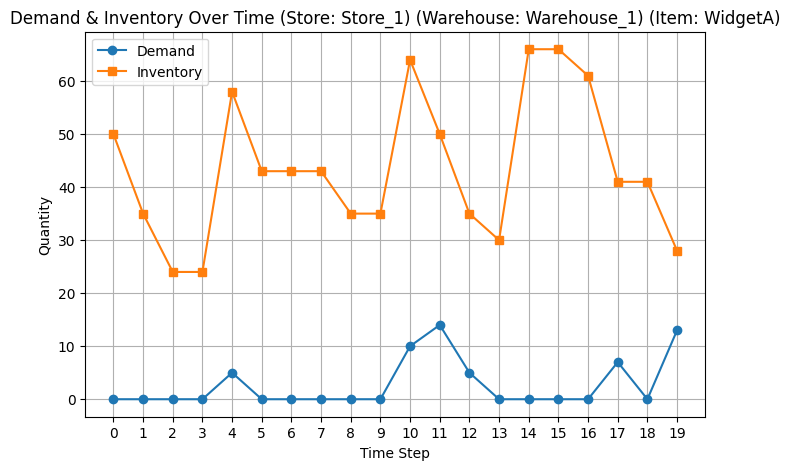

In [65]:
# Instantiate supply chain objects
warehouse1 = Warehouse("Warehouse_1", capacity=1000)
# initial inventory
warehouse1.add_inventory("WidgetA", 50)
warehouse1.add_inventory("WidgetB", 40)
warehouse1.add_inventory("WidgetC", 60)

truck1 = Truck("Garage", capacity=50)
store1 = Store("Store_1", {"WidgetA": 10})
store2 = Store("Store_2", {"WidgetB": 5})

# Create simulation with restocking threshold = 20, restock_amount = 50
sim = SupplyChainSimulation(
    warehouses=[warehouse1],
    trucks=[truck1],
    stores=[store1, store2],
    restock_threshold=20,
    restock_amount=50
)

# Run simulation
sim.run_simulation(steps=20)

# Plot demand & inventory, focusing on WidgetA at Warehouse_1 and Store_1
sim.plot_demand_and_inventory(store_location="Store_1", 
                              warehouse_location="Warehouse_1", 
                              item="WidgetA")

## Optimization example: inventory

In [66]:
import pulp
import matplotlib.pyplot as plt

class Warehouse:
    def __init__(self, location, initial_inventory=0):
        self.location = location
        self.inventory = initial_inventory

class Store:
    def __init__(self, location, demand_over_time):
        """
        demand_over_time: list of demands, one value per time step
        """
        self.location = location
        self.demand_over_time = demand_over_time

class SupplyChainSimulation:
    def __init__(self, warehouse, store,
                 holding_cost=1.0, shortage_cost=5.0, ordering_cost=2.0):
        self.warehouse = warehouse
        self.store = store

        self.holding_cost = holding_cost
        self.shortage_cost = shortage_cost
        self.ordering_cost = ordering_cost

        self.time_step = 0
        self.num_steps = len(self.store.demand_over_time)

        # Logs
        self.inventory_log = []
        self.order_log = []
        self.shortage_log = []
        self.cost_log = []

    def run_simulation(self):
        for t in range(self.num_steps):
            demand_t = self.store.demand_over_time[t]

            # 1) Solve the MILP for reorder
            reorder_qty = self.optimize_inventory(demand=demand_t)

            # 2) Apply reorder
            self.warehouse.inventory += reorder_qty

            # 3) Fulfill store demand
            if self.warehouse.inventory >= demand_t:
                shortage = 0
                self.warehouse.inventory -= demand_t
            else:
                shortage = demand_t - self.warehouse.inventory
                self.warehouse.inventory = 0

            # 4) Calculate costs
            order_cost = self.ordering_cost * reorder_qty
            hold_cost = self.holding_cost * self.warehouse.inventory
            short_cost = self.shortage_cost * shortage
            total_cost = order_cost + hold_cost + short_cost

            # 5) Log
            self.inventory_log.append(self.warehouse.inventory)
            self.order_log.append(reorder_qty)
            self.shortage_log.append(shortage)
            self.cost_log.append(total_cost)

            print(f"Time {t}: Demand={demand_t}, Reorder={reorder_qty}, "
                  f"Ending Inventory={self.warehouse.inventory}, Shortage={shortage}, "
                  f"Cost={total_cost:.2f}")

    def optimize_inventory(self, demand):
        """
        Solve a single-period MILP to decide reorder quantity,
        given current warehouse inventory and known demand for THIS time step.
        """
        problem = pulp.LpProblem("InventoryOptimization", pulp.LpMinimize)

        # Decision variables
        reorder_var = pulp.LpVariable('reorder_qty', lowBound=0, cat=pulp.LpInteger)
        final_inv = pulp.LpVariable('final_inv', lowBound=0, cat=pulp.LpInteger)     # On-hand inventory after demand
        shortage_var = pulp.LpVariable('shortage', lowBound=0, cat=pulp.LpInteger)  # Unmet demand

        # Enforce the balance: final_inv + shortage = current_inv + reorder - demand
        problem += (final_inv + shortage_var == self.warehouse.inventory + reorder_var - demand)

        # Objective: ordering cost + holding cost + shortage cost
        cost_expr = (self.ordering_cost * reorder_var
                     + self.holding_cost * final_inv
                     + self.shortage_cost * shortage_var)
        problem += cost_expr

        # Solve
        problem.solve(pulp.PULP_CBC_CMD(msg=0))
        reorder_qty = int(pulp.value(reorder_var))
        return reorder_qty

    def plot_results(self):
        t = range(self.num_steps)

        plt.figure(figsize=(12,8))

        plt.subplot(2,2,1)
        plt.plot(t, self.order_log, marker='o', label='Reorder Qty')
        plt.title("Reorder Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Units")
        plt.grid(True)

        plt.subplot(2,2,2)
        plt.plot(t, self.inventory_log, marker='o', color='g', label='Inventory')
        plt.title("Inventory Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Units on Hand")
        plt.grid(True)

        plt.subplot(2,2,3)
        plt.plot(t, self.shortage_log, marker='o', color='r', label='Shortage')
        plt.title("Shortage Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Unmet Demand")
        plt.grid(True)

        plt.subplot(2,2,4)
        plt.plot(t, self.cost_log, marker='o', color='purple', label='Cost')
        plt.title("Cost Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Cost")
        plt.grid(True)

        plt.tight_layout()
        plt.show()


Time 0: Demand=10, Reorder=0, Ending Inventory=0, Shortage=0, Cost=0.00
Time 1: Demand=25, Reorder=25, Ending Inventory=0, Shortage=0, Cost=50.00
Time 2: Demand=30, Reorder=30, Ending Inventory=0, Shortage=0, Cost=60.00
Time 3: Demand=40, Reorder=40, Ending Inventory=0, Shortage=0, Cost=80.00
Time 4: Demand=10, Reorder=10, Ending Inventory=0, Shortage=0, Cost=20.00
Time 5: Demand=30, Reorder=30, Ending Inventory=0, Shortage=0, Cost=60.00
Time 6: Demand=50, Reorder=50, Ending Inventory=0, Shortage=0, Cost=100.00
Time 7: Demand=60, Reorder=60, Ending Inventory=0, Shortage=0, Cost=120.00
Time 8: Demand=20, Reorder=20, Ending Inventory=0, Shortage=0, Cost=40.00
Time 9: Demand=10, Reorder=10, Ending Inventory=0, Shortage=0, Cost=20.00


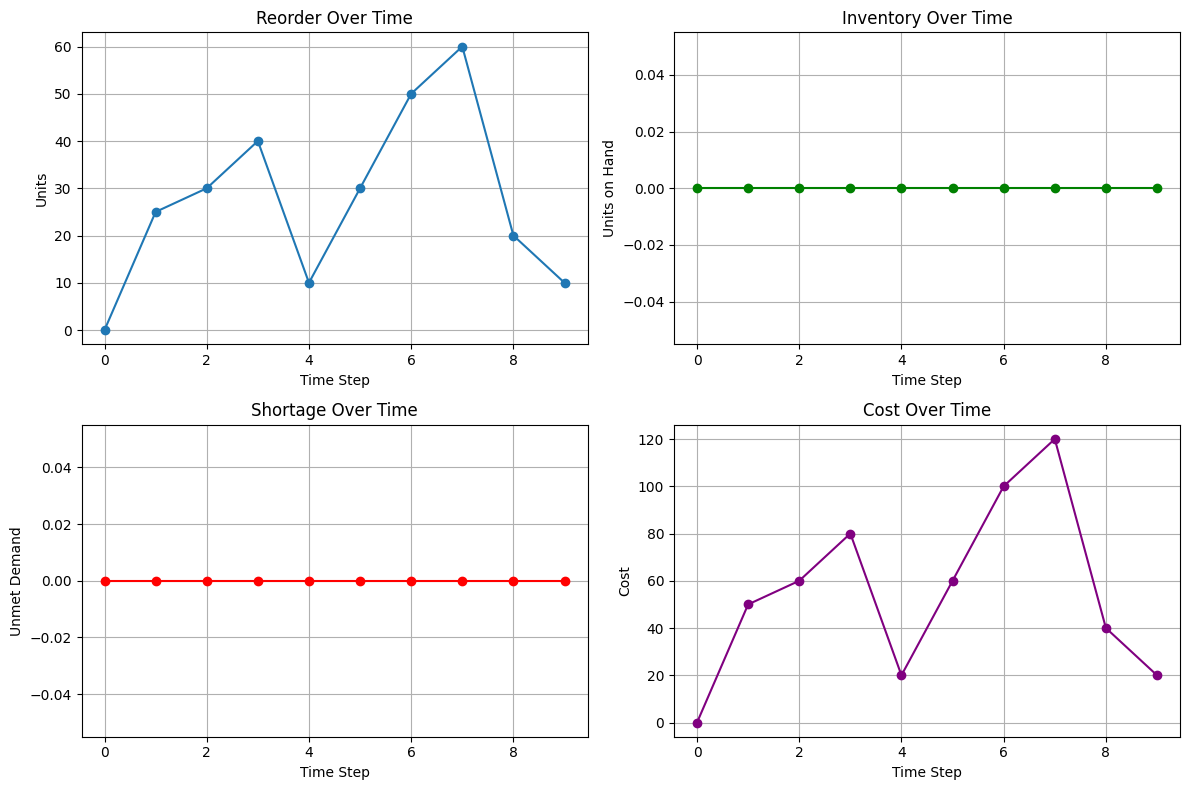

In [67]:
class Warehouse:
    def __init__(self, location, initial_inventory=0):
        self.location = location
        self.inventory = initial_inventory

class Store:
    def __init__(self, location, demand_over_time):
        self.location = location
        self.demand_over_time = demand_over_time

def example_inventory_optimization():
    store_demand = [10, 25, 30, 40, 10, 30, 50, 60, 20, 10]
    store1 = Store(location="Store_1", demand_over_time=store_demand)
    warehouse1 = Warehouse(location="Warehouse_1", initial_inventory=10)

    sim = SupplyChainSimulation(
        warehouse=warehouse1,
        store=store1,
        holding_cost=1.0,
        shortage_cost=5.0,
        ordering_cost=2.0
    )
    sim.run_simulation()
    sim.plot_results()

example_inventory_optimization()
